# Physics-Informed Neural Network

## 简介
传统的科学研究是在理论和实验之间螺旋上升. 今天机器学习方法快速发展,  甚至可以把理论抛在一边, 单纯使用 data-driven 的方法来研究问题. (很难说这是好事坏事) 这种 Purely data-driven 方法的 “naivety" 在于: 我们明明知道关于一个物理过程的很多信息, 最终却都没有用到. 最近提出来的一个方法叫做 *physics-informed neural network*, 简单说就是把已知的关于物理过程的信息 (以 differential equations 的形式) 直接加到 loss function 中. 比如下面的 loss function.
$$\min \frac{1}{N}\sum^N_i (u_{\rm{NN}}(x_i;\theta) - u_{\rm{true}}(x_i))^2 + \frac{1}{M}\Big(\Big[m\frac{d^2}{dx^2} + \mu\frac{d}{dx} + k \Big] u_{\rm{NN}}(x_j;\theta)\Big)^2$$
注意增加的项, 用以保证神经网络找到的解与已知的物理学过程相符.

我们知道, NN 可以做为一个 universal function approximator, 即通过已知的数据来推测函数的全貌. 这里面隐含着一个前提: 除了这些实验数据, 我们完全不知道关于函数的其他信息. 可是, 如果我们知道呢? 比如, 我们知道这个函数 $f(t)$ 代表人口随时间的增长, 且满足增长模型:
$$\frac{df}{dt} = Rt(1-t)$$
此处 $R$ 表示最大人口增长速度. 当然还有一些边界条件, 比如在 $t=0$ 时有 $f(t=0)=1$.

我们希望 NN 的结果也满足以上 differential equation, 于是应该有:
$$\frac{df_{\rm{NN}}(t)}{dt} - Rt(1-t) = 0$$
这里 $f_{\rm{NN}}(t)$ 表示 NN 的输出值, 导数可以通过 NN 的自动求导功能直接得到. 通常, 我们不会把在所有的输入点都计算这个项, 而是选择一个子集 (叫做 colocation points) 来计算:
$$\mathcal{L}_{\rm{DE}} = \frac{1}{M}\sum^M_{j=1}\Big( \frac{df_{\rm{NN}}}{dt} \bigg|_{x_j} - Rx_j(1-x_j)\Big)^2$$
此外, 还有边界条件:
$$\mathcal{L}_{\rm{BC}} = (f_{\rm{NN}}(t_0) - 1)^2 \text{ with } t_0 = 0$$
最终的 loss function 将包含以上两项:
$$\mathcal{L} = \mathcal{L}_{DE} + \mathcal{L}_{BC}$$

## 小试牛刀
根据以上介绍， 就可以来尝试实现 Physics-Informed Neural Network 了. 首先使用 PyTorch 构建一个简单的神经网络做为 Universal Function Approximator:

In [2]:
from torch import nn

class NNApproximator(nn.Module):
    """Simple neural network accepting one feature as input and returning a single output
    """    
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):
        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

In [3]:
import torch

def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)

def df(nn: NNApproximator, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to the input feature(s) using PyTorch autograd engine"""
    df_value = f(nn, x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value

重点是 Loss Function 的构建， 这里就体现出神经网络类框架的有点了 --- 自动求导。

In [6]:
def compute_loss(
    nn: NNApproximator, x: torch.Tensor = None, verbose: bool = False
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    interior_loss = df(nn, x) - R * x * (1 - x)

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_loss = f(nn, boundary) - F0
    final_loss = interior_loss.pow(2).mean() + boundary_loss ** 2
    return final_loss

In [8]:
from typing import Callable

import torch
from torch import nn
import numpy as np

def train_model(
    nn: NNApproximator,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> NNApproximator:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):
        try:
            loss: torch.Tensor = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)


def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)

我们尝试一下

In [14]:
import numpy as np
from scipy.integrate import solve_ivp
from functools import partial
import matplotlib.pyplot as plt
plt.style.use('ggplot')

R = 1.0
F0 = 1.0

domain = [0.0, 1.0]
x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
x = x.reshape(x.shape[0], 1)

nn_approximator = NNApproximator(4, 10)
assert check_gradient(nn_approximator, x)

# f_initial = f(nn_approximator, x)
# ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")

# train the PINN
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=20_000
)

x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
)

Epoch: 0 - Loss: 1.491026
Epoch: 1000 - Loss: 0.004569
Epoch: 2000 - Loss: 0.000518
Epoch: 3000 - Loss: 0.000386
Epoch: 4000 - Loss: 0.000295
Epoch: 5000 - Loss: 0.000230
Epoch: 6000 - Loss: 0.000183
Epoch: 7000 - Loss: 0.000149
Epoch: 8000 - Loss: 0.000125
Epoch: 9000 - Loss: 0.000106
Epoch: 10000 - Loss: 0.000093
Epoch: 11000 - Loss: 0.000083
Epoch: 12000 - Loss: 0.000075
Epoch: 13000 - Loss: 0.000070
Epoch: 14000 - Loss: 0.000065
Epoch: 15000 - Loss: 0.000062
Epoch: 16000 - Loss: 0.000060
Epoch: 17000 - Loss: 0.000080
Epoch: 18000 - Loss: 0.000110
Epoch: 19000 - Loss: 0.000099


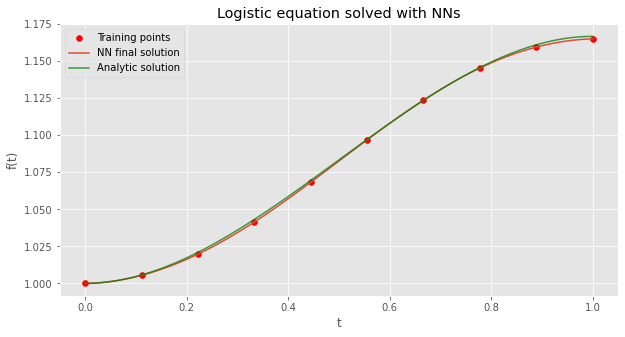

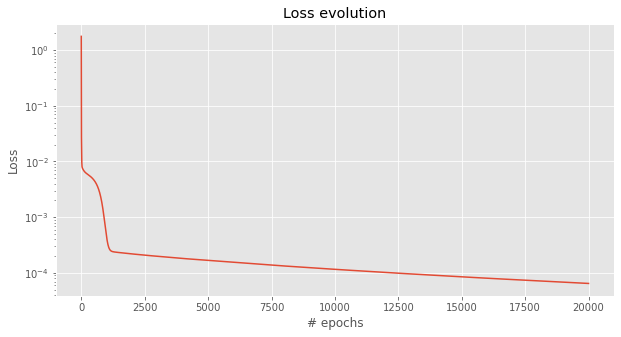

In [13]:
## Plot 1
fig, ax = plt.subplots(figsize=(10, 5))

f_final_training = f(nn_approximator_trained, x)
f_final = f(nn_approximator_trained, x_eval)

ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
ax.plot(
    x_eval.detach().numpy(),
    numeric_solution.y.T,
    label=f"Analytic solution",
    color="green",
    alpha=0.75,
)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()

## Plot 2
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")

plt.show()

## 另一个例子： 解决 Single ODE

考虑如下 ODE:
$$
\frac{d\Psi}{dx} = f(x, \Psi),
$$
with $x \in [0,1]$ and initial conditions (IC):
$$
\Psi(0) = A.
$$
尝试如下解:
$$
\hat{\Psi}(x; \theta) = A + x N(x; \theta),
$$
where $N(x; \theta)$ is a neural network (NN). The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions. The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{d\hat{\Psi}(x;\theta)}{dx} - f(x,\hat{\Psi}(x;\theta))\right]^2dx
$$

我们这里使用 [Lagaris et al](https://arxiv.org/pdf/physics/9705023.pdf) 论文介绍的方法，他们没有使用 stochastic optimization 的方法, 而是使用了大量的抽样来估计 loss integral, 然后再使用 gradient-based optimization 方法 (比如 BFGS).

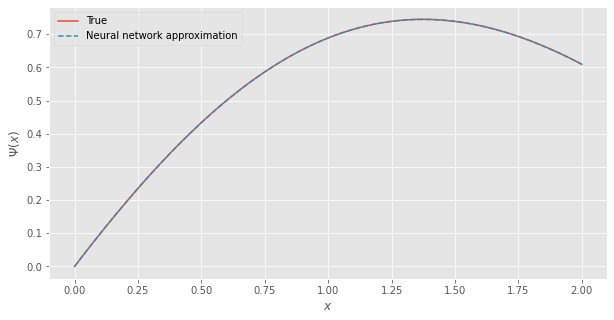

In [16]:
import torch
import torch.nn as nn

# N is a Neural Network - This is exactly the network used by Lagaris et al. 1997
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Initial condition
A = 0.

# The Psi_t function
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

# The loss function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points used by Lagaris
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l
    
for i in range(10):
    optimizer.step(closure)

# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best')
plt.show()

In [17]:
# We need to reinitialize the network
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Let's see now if a stochastic optimizer makes a difference
adam = torch.optim.Adam(N.parameters(), lr=0.01)

# The batch size you want to use (how many points to use per iteration)
n_batch = 5

# The maximum number of iterations to do
max_it = 1000

for i in range(max_it):
    # Randomly pick n_batch random x's:
    x = 2 * torch.rand(n_batch, 1)
    # Zero-out the gradient buffers
    adam.zero_grad()
    # Evaluate the loss
    l = loss(x)
    # Calculate the gradients
    l.backward()
    # Update the network
    adam.step()
    # Print the iteration number
    if i % 100 == 99:
        print(i+1)

100
200
300
400
500
600
700
800
900
1000


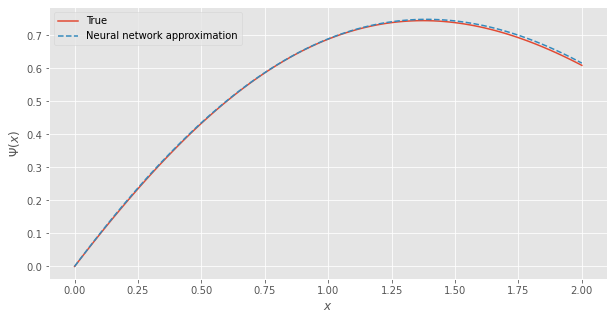

In [19]:
# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best')
plt.show()